## Christian Hansen

## Classifying News by either local news or local weather based on text.

Setting up an API and after getting a key I made calls to the api to get 100 pages maximum at a time. This presented itself with some issues as I had to set an offset and a category set to US_West. 

In [1]:
import requests
## get a free key from bing!
key = ###
def bing_search(query,count,offset, key):
    url = 'https://api.cognitive.microsoft.com/bing/v5.0/news/search'
    # query string parameters
    payload = {'q': query,'count':count,'offset':offset,'category': 'US_West'}
    # custom headers
    headers = {'Ocp-Apim-Subscription-Key':key}
    # make GET request
    r = requests.get(url, params=payload, headers=headers)
    # get JSON response
    return r.json()

### Funtions to aid in getting both the weather and the news from separate url calls. Weather news was given a column of true and the regular SF news was set to False. 

def get_articles(json_,boolean):
    news_array = []
    for w in json_['value']:
#         print(w['name'],'<***>',w['description'],'<------->',w['url'])
#         print('---------------------------------------------------------------------')
#         print('******************')
        news_array.append([w['name'],w['description'], w['url'],boolean])
    return(news_array)

def pull_articles(start_,stop_):
    ## looping through offset to get multiple 100 pages
    # to begin again uncomment below and set range from 0 to number_of_counts
    total_news = []
    total_weather = []
    for off in range(start_,stop_):
        weather = bing_search('san francisco Weather',100,off*100,key)
        total_weather += get_articles(weather,True)
        san_fran = bing_search('news san francisco',100,off*100,key)
        total_news += get_articles(san_fran,False)
        
    total_array = total_news + total_weather
    return(total_array,len(total_news))

In [2]:
def total_array_to_dataframe(news_article):
    # Make a dataframe with columns name, description, url, and news_type(the boolean true false)
    import pandas as pd
    df = pd.DataFrame(data = total_array, columns = ['name','description','url','news_type'])
    df = df.drop_duplicates(keep ='first',subset = 'name')
    df.to_csv('news_weather.csv',encoding='utf-8')
    return(df)

In [3]:
total_array, length = pull_articles(0,1)
df = total_array_to_dataframe(total_array)

In [4]:
def run_model_pipeline_grid(df_read_in):
    features = df_read_in[['name','description']]
    target = df_read_in['news_type']
    from sklearn.cross_validation import train_test_split
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    
    #Train test split is performed to get a better understanding of how the model is performing. 
    #It's important to look at to decide hyperparameters how the model will be generalized and behave when given new data.

    X_train, X_test, y_train, y_test = train_test_split(features,target,test_size = 0.2)
    text_clf_1 = Pipeline([('vect', CountVectorizer(stop_words="english", 
                    token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b")),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier()),])
    text_clf_1.fit(X_train['description'], y_train)  
    parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'clf__n_estimators': (5,10,15),
                'clf__max_depth':(2,3,4,5,6,10,20)}
    ## Using a gridisearch to help tune the model parameters
    gs_clf_1= GridSearchCV(text_clf_1, parameters, n_jobs=1)
    gs_clf_1= gs_clf_1.fit(X_train['description'],y_train)
    print(X_train.shape,y_train.shape)
    
    print(gs_clf_1.best_score_) 
    gs_clf_1.cv_results_
    
    return(gs_clf_1.best_estimator_,X_train,X_test,y_train,y_test,features,target)

In [5]:
model,X_train,X_test,y_train,y_test,features,target = run_model_pipeline_grid(df)

model

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


((156, 2), (156,))
0.820512820513


Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
     ...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [6]:
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import seaborn
def analyze_model(model,X_test,y_test):
    
    ## Looking at the predictive power of the model: ROC-Curve and Precision-Recall
    
    predict = model.predict_proba(X_test['description'])[:,1]
    prec, rec, thresh_ = precision_recall_curve(y_test,predict)
    fpr,tpr, thresh2 = roc_curve(y_test,predict)

    ## plot precision recall curve
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(rec,prec)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('Precision Recall Curve')

    plt.subplot(1,2,2)
    plt.plot(fpr,tpr)
    plt.plot([1,0], [1,0], 'k--', lw=2)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('Reciever Operator Charactoristics')
    plt.show()

    print('TPR and FPR versus Threshold Separetely')
    print('-------------------------------------------------------------------------------')
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    # F1 = 2 * (prec * rec) / (prec + rec)
    thresh = list(thresh_)
    # thresh.append(1)
    plt.plot(thresh2,tpr)
    plt.title('TPR Versus Threshold')
    plt.ylabel('tpr')
    plt.xlabel('Threshold')

    plt.subplot(1,2,2)
    # F1 = 2 * (prec * rec) / (prec + rec)
    thresh = list(thresh2)
    # thresh.append(1)
    plt.plot(thresh,fpr)
    plt.title('FPR Versus Threshold')
    plt.ylabel('fpr')
    plt.xlabel('Threshold')
    plt.show()
    return(predict)

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


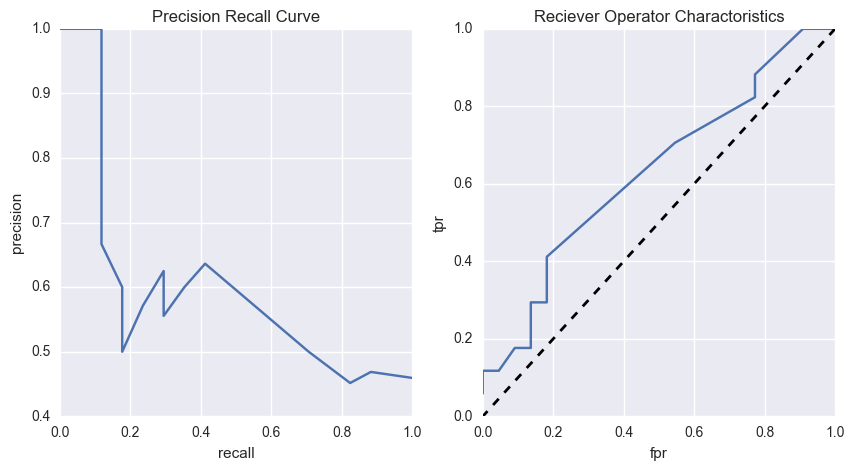

TPR and FPR versus Threshold Separetely
-------------------------------------------------------------------------------


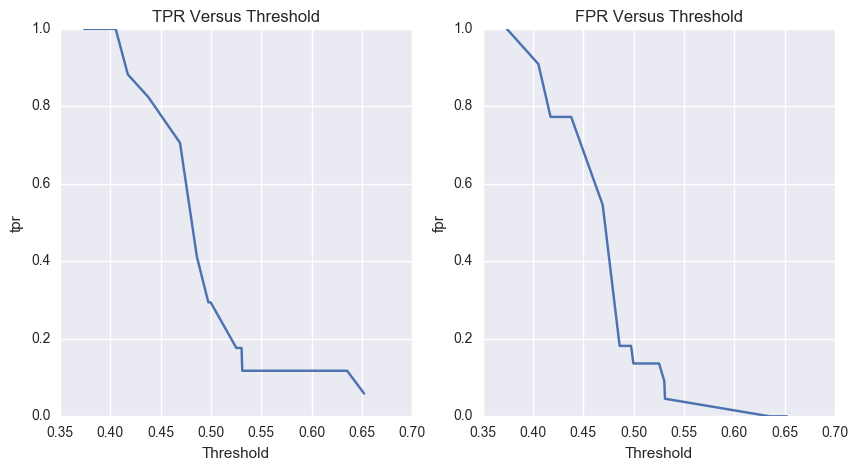

In [7]:
pred = analyze_model(model,X_test,y_test)
# This offers insight into where to make a hard predictor and how our binary classifier is performing over all thresholds.
# However it already appears there is overfitting. We're doing too good of a job.

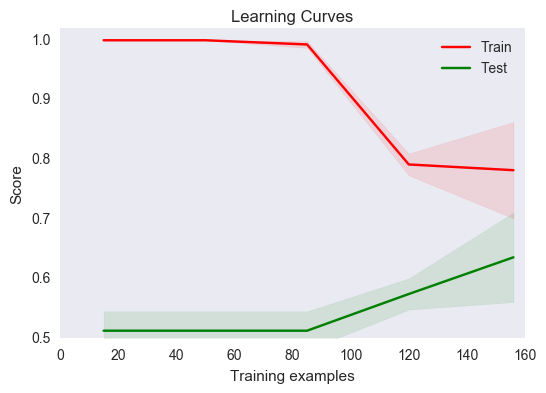

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '-', color="r",
             label="Train")
    plt.plot(train_sizes, test_scores_mean, '-', color="g",
             label="Test")

    plt.legend(loc="best")
    return plt

from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle = True)
plot_learning_curve(model, "Learning Curves", features['description'], target, (0.5, 1.02), cv=kf, n_jobs=1)
plt.show()

## Model Performance
Both the variations in MultinomialNB and the RandomForest train very well on the tfidf vectorized description and name data. This could be solved with far more data then I have here to get more variation in the training set. In other words it's doing a very good job at being fine-tuned to the training and doing a worse job on the testing. As you can see by the Learning curves for the model the higher the complexity of the model (the training samples) the lower the training score and the higher the testing score. Adding more observations/articles would be the greatest asset to the model, but other features could be useful, I could even combine the name and the description or perhaps the name and look into data on the webpage, but this could be an exuastive persuit as going into each url and scraping information presents its own bottleneck on top of the current problems I've encountered. 

## Bottleneck
The bottleneck that I encountered and cannot seem to work through is the API's call and the offset necessary to get unique articles. I was able to catch that I was not catching new articles and this greatly improved the models as that greatly can skew the models bias. 

## Attempted Solution

The API for the search needs a category in the url so I put it to 'US_West'and attempted to offset the search for an article by 100 as I pulled a hundred articles at a time. Most results done this way would return far less than 100 per call and could be duplicates as well. Perhaps this is an error in my reading of the documentation, but it suggests there may be duplicates in the calls. For the duplicates the url is different, but the name and descriptions are the same. Perhaps I am just running into redundant articles in the system. This is good to know and something to avoid in the future in case I have to make these calls to the api again.

## Assuming this is all the data I had:
I would attempt to regularize the models or use classification models such as L1 or L2 to select features or provide regularization. But, thinking back to a good rule of thumb of having more features than observations, I have so few observations in comparison to features, that I would not be making a very robust model when it would be given new data to test or predict on. 

To add a little regularization into the randomforest model I limited the depth of the trees and could also implement other limits to the tree growth, but as the learning curves indicate the more data points the stronger the model performs and the training and test set converge.

Mostly I spent a lot of time working with the API and accidently making too many calls and setting up a new account and using an AWS EC2 to overcome the monthly cap of 10,000 calls on my local. 